# Emerging topics final code - Full (new code cleaning)

In [120]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns
import os

from gensim.models.coherencemodel import CoherenceModel

import statsmodels.api as sm

## Data ingestion

In [121]:
# full corpus
df = pd.read_pickle("/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/FR_meta_and_final_tokens_21SEPT14.pkl")

In [122]:
df.head()

,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,0,89996,"This is a project to explore Game-based, Metap...",2008,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,"[project, explore, game, base, metaphor, enhan..."
1,1,89997,Institution: Franklin Institute Science Museum...,2008,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,"[institution, franklin_institute, science, mus..."
2,2,89998,Through programs (including small group conver...,2008,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,"[program, small, group, conversation, citizen,..."
3,3,89999,In partnership with the American Chemical Soci...,2008,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,"[partnership, american, chemical, society, acs..."
4,5,90001,The Center for Molecular Interfacing (CMI) wil...,2008,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,"[center, molecular, interfacing, cmi, enable, ..."


In [123]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_tokens"]

for abstract in docs:
    text.append(" ".join(abstract))

In [124]:
'''
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['study'], \
                               id2word.token2id['project']])

    return id2word
'''

In [125]:
#id2word = createLDAvars(docs)

## Functions needed for all models

In [5]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def list_topics(topic_term_dist, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_dist):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words

In [6]:
def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- 50 topics, random state = ?

In [7]:
stop_wds = ['research', 'study', 'project']  # use will be eliminated by max_df

In [8]:
# construct term document matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [130]:
# first time topic model run
#num_topics = 100

#nmf_model = NMF(n_components = num_topics, random_state = 1)
#doc_topic = nmf_model.fit_transform(tf_idf)
#topic_term = nmf_model.components_

In [131]:
#with open("/project/biocomplexity/sdad/projects_data/ncses/prd/nmf_full_100.pkl","wb") as f:
#    pickle.dump((doc_topic, topic_term), f)

In [9]:
# read in fit topic model
num_topics = 50

with open("/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/nmf_full_50.pkl", "rb") as f:
    res = pickle.load(f)
    
doc_topic = res[0]
topic_term = res[1]

In [10]:
topics = list_topics(topic_term, tfidf_vectorizer, top_n = 10)

In [134]:
# calculate coherence
#cm = CoherenceModel(topics = topics,
#                    #corpus = corpus,
#                    dictionary = id2word,
#                    texts = docs, 
#                    coherence = 'c_v', 
#                    processes = 8)

## Emerging topics

In [11]:
# Extract Year from PROJECT_START_DATE

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [12]:
# add start year to doc topic matrix
topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]

In [13]:
st_yr = 2010
end_yr = 2019

#### compute count of projects with weight > 0 for each topic

In [14]:
topic_proj_count = topic_frame.copy()

In [15]:
# count number of docs with weight > 0
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [16]:
# count number of docs with weight > 0 BY YEAR
topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)

In [17]:
# get docs between 2010 and 2019 (or st_yr and end_yr)

topic_counts_filt = topic_counts[topic_counts["START_YEAR"] >= st_yr] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] <= end_yr]

In [18]:
n_by_topic = topic_counts_filt.sum()[1:]

In [19]:
len(n_by_topic)

50

#### calculate mean topic weight by year and standard errors on means

In [20]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] >= st_yr] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] <= end_yr]

In [21]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [22]:
# filter topic_frame for years 2010 - 2019 (st_yr to end_yr)

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] >= st_yr] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] <= end_yr] 

In [23]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,...,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Topic 31,Topic 32,Topic 33,Topic 34,Topic 35,Topic 36,Topic 37,Topic 38,Topic 39,Topic 40,Topic 41,Topic 42,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49
40,2010,0.000645,0.001763,0.002138,0.001244,0.001554,0.000800,0.001622,0.001507,0.000761,0.001788,0.000710,0.000533,0.001669,0.001019,0.000378,0.000812,0.000314,0.000999,0.001149,0.001042,0.001274,0.000907,0.001030,0.001132,...,0.000516,0.001154,0.001050,0.001168,0.001532,0.001375,0.000816,0.001572,0.000581,0.001264,0.000824,0.000835,0.000722,0.001844,0.001540,0.001594,0.000703,0.001300,0.000995,0.002290,0.002870,0.001898,0.002739,0.002597,0.001436
41,2011,0.000643,0.001757,0.002190,0.001253,0.001627,0.000811,0.001602,0.001489,0.000761,0.001766,0.000772,0.000543,0.001631,0.001034,0.000394,0.000851,0.000349,0.000943,0.001136,0.001047,0.001319,0.000990,0.000989,0.001146,...,0.000553,0.001098,0.001100,0.001266,0.001519,0.001313,0.000844,0.001522,0.000539,0.001295,0.000823,0.000829,0.000723,0.001915,0.001558,0.001647,0.000748,0.001389,0.000966,0.002403,0.002859,0.001974,0.002676,0.002671,0.001461
42,2012,0.000690,0.001822,0.002222,0.001392,0.001685,0.000878,0.001630,0.001353,0.000888,0.001855,0.000801,0.000599,0.001573,0.001006,0.000433,0.000916,0.000398,0.000888,0.001062,0.001095,0.001339,0.001038,0.001142,0.001165,...,0.000546,0.001156,0.001166,0.001322,0.001656,0.001393,0.000822,0.001386,0.000595,0.001475,0.000753,0.000984,0.000716,0.002021,0.001694,0.001737,0.000838,0.001496,0.000974,0.002557,0.002789,0.002141,0.002553,0.003000,0.001478
43,2013,0.000624,0.001821,0.002185,0.001243,0.001635,0.000721,0.001836,0.001217,0.000765,0.001723,0.000680,0.000544,0.001911,0.001124,0.000382,0.000849,0.000369,0.001039,0.001286,0.001158,0.001274,0.000934,0.001025,0.001088,...,0.000501,0.001063,0.001132,0.001386,0.001467,0.001743,0.000762,0.001362,0.000562,0.001285,0.000696,0.000846,0.000676,0.001894,0.001503,0.001505,0.000690,0.001337,0.001077,0.002270,0.003094,0.001962,0.002755,0.002493,0.001439
44,2014,0.000623,0.001761,0.002255,0.001283,0.001702,0.000754,0.001818,0.001214,0.000763,0.001676,0.000700,0.000518,0.001750,0.001151,0.000388,0.000850,0.000412,0.001046,0.001308,0.001090,0.001378,0.000987,0.001003,0.001130,...,0.000456,0.001034,0.001115,0.001386,0.001449,0.001572,0.000744,0.001402,0.000553,0.001324,0.000718,0.000860,0.000750,0.001898,0.001517,0.001481,0.000720,0.001375,0.001112,0.002100,0.003112,0.001918,0.002763,0.002507,0.001479
45,2015,0.000584,0.001757,0.002217,0.001290,0.001622,0.000733,0.001963,0.001089,0.000786,0.001549,0.000700,0.000530,0.001891,0.001223,0.000377,0.000891,0.000399,0.001067,0.001331,0.001152,0.001374,0.000925,0.001004,0.001045,...,0.000454,0.000996,0.001027,0.001340,0.001296,0.001665,0.000693,0.001379,0.000546,0.001301,0.000650,0.000787,0.000668,0.001831,0.001444,0.001401,0.000764,0.001292,0.001195,0.002184,0.003227,0.002044,0.002839,0.002582,0.001424
46,2016,0.000587,0.001823,0.002214,0.001272,0.001536,0.000774,0.001979,0.001084,0.000854,0.001520,0.000759,0.000539,0.001988,0.001226,0.000370,0.000846,0.000466,0.001074,0.001183,0.001177,0.001391,0.000922,0.001016,0.001048,...,0.000490,0.001003,0.001086,0.001321,0.001339,0.001390,0.000679,0.001409,0.000515,0.001384,0.000600,0.000810,0.000556,0.001811,0.001491,0.001487,0.000711,0.001426,0.001226,0.002261,0.003273,0.002048,0.002837,0.002497,0.001421
47,2017,0.000609,0.001872,0.002349,0.001395,0.001568,0.000822,0.001938,0.001111,0.000948,0.001564,0.000830,0.000543,0.002000,0.001266,0.000356,0.000869,0.000567,0.001037,0.001047,0.001158,0.001441,0.000972,0.000972,0.001088,...,0.000461,0.000985,0.001120,0.001402,0.001367,0.000975,0.000673,0.001443,0.000534,0.001475,0.000586,0.000888,0.000558,0.001882,0.001507,0.001581,0.000883,0

In [24]:
# fit OLS and get slope, SE, p-value
topic_slopes = []
topic_slopes_se = []
topic_slopes_pval = []

lm_x = topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1)
lm_x = sm.add_constant(lm_x)

for i in range(1,num_topics+1):

    linear_fit = sm.OLS(topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1),lm_x).fit()
    
    topic_slopes.append(linear_fit.params[1])
    topic_slopes_se.append(linear_fit.bse[1])
    topic_slopes_pval.append(linear_fit.pvalues[1])

In [25]:
topic_ols_res = pd.DataFrame(
    {"Slope": topic_slopes, 
     "SE": topic_slopes_se,
     "p-value": topic_slopes_pval
     #"n": n_by_topic
    })

In [26]:
topic_ols_res = topic_ols_res.reset_index(drop = True)

In [27]:
reg_topics = pd.DataFrame()
reg_topics["Topic Words"] = str_topics(topic_term, tfidf_vectorizer, top_n = 5)

In [28]:
regression_res = pd.concat([reg_topics, topic_ols_res], axis = 1)

In [29]:
regression_res = regression_res.sort_values('Topic Words')

In [30]:
topic_label_num = range(1, num_topics + 1)
topic_label = ["FR" + str(x) for x in topic_label_num]  # FR, X, Y, or Z
regression_res["Topic Label"] = topic_label

In [31]:
regression_res

,Topic Words,Slope,SE,p-value,Topic Label
16,"ad, alzheimer, tau, dementia, pathology",5.479719e-05,0.000012,0.002233,FR1
28,"administrative, core, scientific, meeting, coo...",6.096736e-06,0.000009,0.537303,FR2
34,"aging, cognitive, age, memory, older",5.341236e-05,0.000018,0.017458,FR3
25,"alcohol, ethanol, drinking, consumption, abuse",6.401685e-06,0.000009,0.500910,FR4
33,"bone, tissue, fracture, osteoporosis, osteoblast",3.402227e-06,0.000005,0.506452,FR5
10,"brain, tbi, injury, neural, mri",2.472112e-05,0.000010,0.033721,FR6
35,"breast, cancer, woman, er, estrogen",-2.100621e-05,0.000008,0.027553,FR7
4,"cancer, ovarian, nci, pancreatic, member",1.251634e-05,0.000011,0.294593,FR8
0,"cell, stem, differentiation, tissue, progenitor",1.587999e-06,0.000006,0.802127,FR9
47,"center, resource, support, investigator, facility",-1.406537e-05,0.000019,0.475676,FR10


In [ ]:
#regression_res.to_csv("full_50_topics_2018_df.csv", index=False)

## Create plot - top 10 hot and cold topics

In [32]:
top_slopes = regression_res.nlargest(10, 'Slope')

In [33]:
top_slopes

,Topic Words,Slope,SE,p-value,Topic Label
46,"intervention, behavior, treatment, social, beh...",0.000062,0.000021,0.019869,FR28
16,"ad, alzheimer, tau, dementia, pathology",0.000055,0.000012,0.002233,FR1
34,"aging, cognitive, age, memory, older",0.000053,0.000018,0.017458,FR3
3,"patient, care, treatment, outcome, therapy",0.000049,0.000019,0.032914,FR36
41,"pain, chronic, opioid, treatment, analgesic",0.000047,0.000018,0.028489,FR35
42,"neuron, circuit, neural, neuronal, motor",0.000042,0.000015,0.024665,FR34
49,"dr, career, mentor, award, director",0.000033,0.000017,0.095661,FR18
20,"clinical, trial, protocol, translational, phase",0.000032,0.000008,0.003528,FR12
48,"disease, human, kidney, infectious, pd",0.000031,0.000031,0.340591,FR16
40,"heart, cardiac, vascular, injury, mitochondrial",0.000029,0.000025,0.282512,FR22


In [34]:
top_slopes.index

Int64Index([46, 16, 34, 3, 41, 42, 49, 20, 48, 40], dtype='int64')

In [37]:
start_wts = topic_wts_2010_2019[topic_wts_2010_2019['START_YEAR'] == st_yr]
start_wts = start_wts.iloc[:,top_slopes.index + 1]
start_wts


,Topic 46,Topic 16,Topic 34,Topic 3,Topic 41,Topic 42,Topic 49,Topic 20,Topic 48,Topic 40
40,0.001898,0.000314,0.001264,0.001244,0.000703,0.0013,0.001436,0.001274,0.002597,0.001594


In [38]:
start_wts.sort_values(by=40, axis=1, ascending = False)

,Topic 48,Topic 46,Topic 40,Topic 49,Topic 42,Topic 20,Topic 34,Topic 3,Topic 41,Topic 16
40,0.002597,0.001898,0.001594,0.001436,0.0013,0.001274,0.001264,0.001244,0.000703,0.000314


In [48]:
leg_order_idx = np.argsort(start_wts.iloc[0,:].tolist())[::-1]
leg_order_idx

array([8, 0, 9, 6, 5, 7, 2, 3, 4, 1])

In [50]:
leg_order = top_slopes.index[leg_order_idx]
leg_order

Int64Index([48, 46, 40, 49, 42, 20, 34, 3, 41, 16], dtype='int64')

In [53]:
top_slopes = top_slopes.loc[leg_order]

In [54]:
top_slopes

,Topic Words,Slope,SE,p-value,Topic Label
48,"disease, human, kidney, infectious, pd",0.000031,0.000031,0.340591,FR16
46,"intervention, behavior, treatment, social, beh...",0.000062,0.000021,0.019869,FR28
40,"heart, cardiac, vascular, injury, mitochondrial",0.000029,0.000025,0.282512,FR22
49,"dr, career, mentor, award, director",0.000033,0.000017,0.095661,FR18
42,"neuron, circuit, neural, neuronal, motor",0.000042,0.000015,0.024665,FR34
20,"clinical, trial, protocol, translational, phase",0.000032,0.000008,0.003528,FR12
34,"aging, cognitive, age, memory, older",0.000053,0.000018,0.017458,FR3
3,"patient, care, treatment, outcome, therapy",0.000049,0.000019,0.032914,FR36
41,"pain, chronic, opioid, treatment, analgesic",0.000047,0.000018,0.028489,FR35
16,"ad, alzheimer, tau, dementia, pathology",0.000055,0.000012,0.002233,FR1


In [55]:
top_leg_topic_label = top_slopes['Topic Label'].tolist()
top_leg = top_slopes['Topic Words'].tolist()
top_leg_label = [i + ": " + j for i, j in zip(top_leg_topic_label, top_leg)]

In [56]:
bottom_slopes = regression_res.nsmallest(10, 'Slope')

In [57]:
bottom_slopes

,Topic Words,Slope,SE,p-value,Topic Label
30,"plant, food, crop, production, soil",-0.000089,0.000035,0.033758,FR37
18,"water, climate, change, ecosystem, forest",-0.000054,0.000026,0.075666,FR50
7,"protein, membrane, structure, bind, complex",-0.000042,0.000011,0.005952,FR40
45,"model, theory, problem, method, computational",-0.000031,0.000057,0.599787,FR31
12,"student, science, stem, school, undergraduate",-0.000027,0.000049,0.598052,FR44
19,"conference, meeting, workshop, researcher, int...",-0.000027,0.000022,0.260734,FR13
17,"material, chemical, property, chemistry, energy",-0.000027,0.000023,0.278029,FR30
9,"gene, expression, genetic, genome, identify",-0.000025,0.000011,0.062219,FR20
35,"breast, cancer, woman, er, estrogen",-0.000021,0.000008,0.027553,FR7
44,"health, community, disparity, care, public",-0.000019,0.000013,0.195198,FR21


In [60]:
bottom_slopes.index

Int64Index([30, 18, 7, 45, 12, 19, 17, 9, 35, 44], dtype='int64')

In [61]:
start_wts = topic_wts_2010_2019[topic_wts_2010_2019['START_YEAR'] == st_yr]
start_wts = start_wts.iloc[:,bottom_slopes.index + 1]
start_wts


,Topic 30,Topic 18,Topic 7,Topic 45,Topic 12,Topic 19,Topic 17,Topic 9,Topic 35,Topic 44
40,0.001375,0.001149,0.001507,0.00287,0.001669,0.001042,0.000999,0.001788,0.000824,0.00229


In [62]:
start_wts.sort_values(by=40, axis=1, ascending = False)

,Topic 45,Topic 44,Topic 9,Topic 12,Topic 7,Topic 30,Topic 18,Topic 19,Topic 17,Topic 35
40,0.00287,0.00229,0.001788,0.001669,0.001507,0.001375,0.001149,0.001042,0.000999,0.000824


In [63]:
leg_order_idx = np.argsort(start_wts.iloc[0,:].tolist())[::-1]
leg_order_idx

array([3, 9, 7, 4, 2, 0, 1, 5, 6, 8])

In [64]:
leg_order = bottom_slopes.index[leg_order_idx]
leg_order

Int64Index([45, 44, 9, 12, 7, 30, 18, 19, 17, 35], dtype='int64')

In [65]:
bottom_slopes = bottom_slopes.loc[leg_order]

In [66]:
bottom_slopes

,Topic Words,Slope,SE,p-value,Topic Label
45,"model, theory, problem, method, computational",-0.000031,0.000057,0.599787,FR31
44,"health, community, disparity, care, public",-0.000019,0.000013,0.195198,FR21
9,"gene, expression, genetic, genome, identify",-0.000025,0.000011,0.062219,FR20
12,"student, science, stem, school, undergraduate",-0.000027,0.000049,0.598052,FR44
7,"protein, membrane, structure, bind, complex",-0.000042,0.000011,0.005952,FR40
30,"plant, food, crop, production, soil",-0.000089,0.000035,0.033758,FR37
18,"water, climate, change, ecosystem, forest",-0.000054,0.000026,0.075666,FR50
19,"conference, meeting, workshop, researcher, int...",-0.000027,0.000022,0.260734,FR13
17,"material, chemical, property, chemistry, energy",-0.000027,0.000023,0.278029,FR30
35,"breast, cancer, woman, er, estrogen",-0.000021,0.000008,0.027553,FR7


In [67]:
bottom_leg_topic_label = bottom_slopes['Topic Label'].tolist()
bottom_leg = bottom_slopes['Topic Words'].tolist()
bottom_leg_label = [i + ": " + j for i, j in zip(bottom_leg_topic_label, bottom_leg)]

### Plot hottest and coldest topics on separate plots

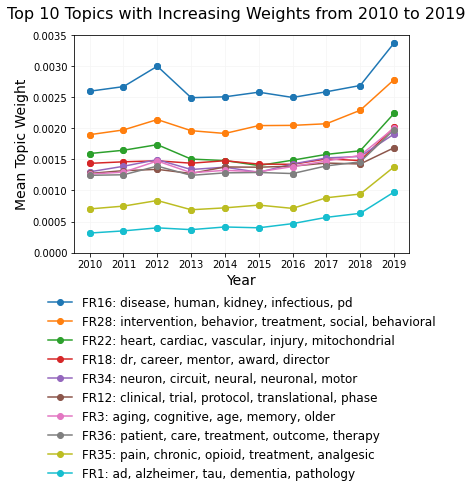

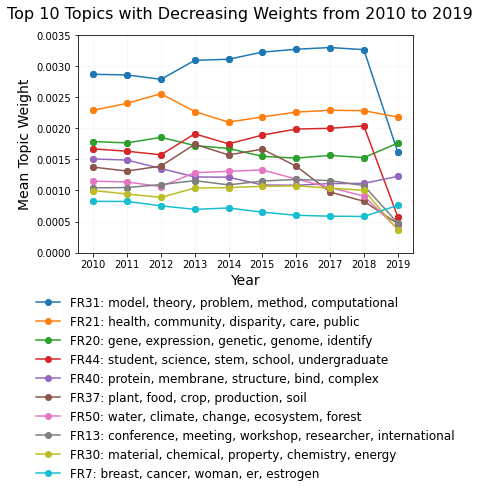

In [68]:
# Make Graphs

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

linestyle_tuple = [
     (0, (1, 10)),
     (0, (1, 1)),

     (0, (5, 10)),
     (0, (5, 5)),
     (0, (5, 1)),

     (0, (3, 10, 1, 10)),
     (0, (3, 5, 1, 5)),
     (0, (3, 1, 1, 1)),

     (0, (3, 5, 1, 5, 1, 5)),
     (0, (3, 10, 1, 10, 1, 10)),
     (0, (3, 1, 1, 1, 1, 1))]

line_return = []
fig = plt.figure()
fig.suptitle('Top 10 Topics with Increasing Weights from 2010 to 2019', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes.index:
    zorder = 10
    color = color_list[i] # "#D3D3D3"   
    if i == 0:
        zorder = 10 #20
        color = color_list[i];
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color = color, zorder = zorder)
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color = color, zorder = zorder, linestyle=linestyle_tuple[i])
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n+1]), fmt = 'o', color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    #line_return.append(mcol.LineCollection(line, linestyles=linestyle_tuple, colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = 0, top = 0.0035)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([top_leg_label[x] for x in range(0,len(top_leg_label))], bbox_to_anchor=(0.35, -0.35, 0.3, 0.2), 
           loc='upper center', fontsize = 'large', frameon = False)
#plt.savefig("et_paper/full_increasing_200_topics_2018.pdf", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top 10 Topics with Decreasing Weights from 2010 to 2019', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes.index:
    zorder = 10
    color = color_list[i]  #"#D3D3D3"  
    if i == 4:
        zorder = 10 #20
        color = color_list[i]
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color=color, zorder = zorder)
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color=color, zorder = zorder, linestyle=linestyle_tuple[i])
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n+1]), fmt = 'o', color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    #line_return.append(mcol.LineCollection(line, linestyles=linestyle_tuple, colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = 0, top = 0.0035)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([bottom_leg_label[x] for x in range(0,len(bottom_leg_label))], bbox_to_anchor=(0.35, -0.35, 0.3, 0.2), 
           loc='upper center', fontsize = 'large', frameon = False)
#plt.savefig("et_paper/full_decreasing_200_topics_2018.pdf", dpi = 800, bbox_inches = "tight")
plt.show()


## Plot for each topic in a grid

In [ ]:
sorted_slopes = regression_res.sort_values('Slope', ascending = False)

In [ ]:
leg_topic_label = sorted_slopes['Topic Label'].tolist()
leg = sorted_slopes['Topic Words'].tolist()
topic_n = sorted_slopes['n'].tolist()
leg_label = [i + ": " + j for i, j in zip(leg_topic_label, leg)]

In [ ]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = 0, top = 0.004)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes.iloc[0:25].index):
    
    #col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,(col_idx+1)].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,(col_idx+1)], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,(col_idx+1)]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    # put legend on two lines for topics 2, 28
    #if count == 0:
    #    ax[i,j].set_title('administrative, scientific, meeting, \n coordinate, management', \
    #                      fontsize = 8)
    #else:
    #    ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    ax[i,j].set_title(leg[count], fontsize = 8)
    
    # add topic number to each plot
    #ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[i,j].transAxes, fontsize = 14)
    #ax[i,j].text(0.08, 0.90, str(col_idx), horizontalalignment='center', verticalalignment='center', \
    #         transform=ax[i,j].transAxes, fontsize = 14)
    ax[i,j].text(0.1, 0.90, leg_topic_label[count], horizontalalignment='center', verticalalignment='center', \
         transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.65, 0.90, "n = " + str(topic_n[count]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
fig.suptitle('Full Corpus Topic Trends from 2010 to 2019 (Part 1)', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("full_50_topic_trends_2018_part1.png", dpi = 800, bbox_inches = "tight")
plt.show()



In [ ]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = 0, top = 0.004)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes.iloc[25:50].index):
    
    #col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,(col_idx+1)].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,(col_idx+1)], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,(col_idx+1)]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    # put legend on two lines for topics 2, 28
    #if count == 0:
    #    ax[i,j].set_title('administrative, scientific, meeting, \n coordinate, management', \
    #                      fontsize = 8)
    #else:
    #    ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    ax[i,j].set_title(leg[count+25], fontsize = 8)
    
    # add topic number to each plot
    #ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[i,j].transAxes, fontsize = 14)
    #ax[i,j].text(0.08, 0.90, str(col_idx), horizontalalignment='center', verticalalignment='center', \
    #         transform=ax[i,j].transAxes, fontsize = 14)
    ax[i,j].text(0.1, 0.90, leg_topic_label[count+25], horizontalalignment='center', verticalalignment='center', \
         transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.65, 0.90, "n = " + str(topic_n[count+25]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
fig.suptitle('Full Corpus Topic Trends from 2010 to 2019 (Part 2)', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("full_50_topic_trends_2018_part2.png", dpi = 800, bbox_inches = "tight")
plt.show()